# Set up

In [1]:
import pandas as pd
import patsy
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Getting data

In [3]:
file_name = '../csvs/element_gameweek_features_v07.csv'

In [4]:
element_gameweek_df = pd.read_csv(file_name)

In [5]:
current_event = 38

In [6]:
last_train_event = 28

In [7]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [8]:
element_gameweek_df = pd.concat([
    element_gameweek_df[element_gameweek_df['element_type'] == i].fillna(
        element_gameweek_df[
            (element_gameweek_df['event'] <= last_train_event)
            & (element_gameweek_df['element_type'] == i)
        ].mean()).fillna(0)
    for i in range(1, 5)
])

In [9]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 30]

In [10]:
element_gameweek_df['is_keeper'] = element_gameweek_df['element_type'].apply(lambda x: 1 if x == 1 else 0)

In [11]:
element_gameweek_df['is_scorer'] = \
element_gameweek_df['rolling_avg_goals_scored_element'].apply(lambda x: 1 if x >= 0.47 else 0)

In [12]:
element_gameweek_df['is_assister'] = \
element_gameweek_df['rolling_avg_assists_element'].apply(lambda x: 1 if x >= 0.5 else 0)

In [25]:
element_gameweek_df['is_high_value'] = \
element_gameweek_df['value'].apply(lambda x: 1 if x >= 9.0 else 0)

# Modelling data

## Splitting data

In [26]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [27]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Scaling data

In [ ]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points', 'is_keeper'
    ]
]

scaled_feature_cols

In [ ]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

## Building model

In [28]:
class FullRankOneHot(object):
    def __init__(self, reference=0):
        self.reference = reference

    # Called to generate a full-rank encoding
    def code_with_intercept(self, levels):
        return patsy.ContrastMatrix(np.eye(len(levels)),
                              ["[%s]" % (level,) for level in levels])

    # Called to generate a non-full-rank encoding. But we don't care,
    # we do what we want, and return a full-rank encoding anyway.
    # Take that, patsy.
    def code_without_intercept(self, levels):
        return self.code_with_intercept(levels)

In [29]:
list(element_gameweek_df.columns)

['safe_web_name',
 'element',
 'event',
 'fixture',
 'team',
 'opposition_team',
 'was_home',
 'is_sunday',
 'is_weekday',
 'is_early',
 'is_late',
 'element_type',
 'value',
 'rolling_value_points',
 'rolling_avg_total_points_element',
 'rolling_q3_total_points_element',
 'rolling_max_total_points_element',
 'has_high_points_ever_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rol

In [30]:
# formula = \
# '''
# total_points ~
# + C(element_type, FullRankOneHot)
# + C(team, FullRankOneHot)
# + C(opposition_team, FullRankOneHot)
# + was_home
# + value
# + rolling_avg_bonus_element
# + rolling_avg_big_chances_created_element
# + is_keeper:rolling_avg_big_chances_created_element
# + rolling_avg_saves_element
# + is_keeper:rolling_avg_saves_element
# + rolling_avg_goals_conceded_element
# + C(element_type, FullRankOneHot):rolling_avg_goals_conceded_element
# + rolling_avg_attempted_passes_element
# + is_keeper:rolling_avg_attempted_passes_element
# + rolling_avg_errors_leading_to_goal_attempt_element
# + C(element_type, FullRankOneHot):rolling_avg_errors_leading_to_goal_attempt_element
# + rolling_avg_penalties_saved_element
# + is_keeper:rolling_avg_penalties_saved_element
# + rolling_avg_yellow_cards_element
# + rolling_avg_minutes_element_p3
# + is_keeper:rolling_avg_minutes_element_p3
# + rolling_avg_total_points_element_p3
# + rolling_avg_goals_scored_opposition_team
# + C(element_type, FullRankOneHot):rolling_avg_goals_scored_opposition_team
# + rolling_q3_goals_conceded_opposition_team
# + C(element_type, FullRankOneHot):rolling_q3_goals_conceded_opposition_team
# + expected_total_points_against_opposition_team
# + rolling_avg_big_chances_element
# + is_keeper:rolling_avg_big_chances_element
# + rolling_avg_big_chances_scored_rate_element
# + is_keeper:rolling_avg_big_chances_scored_rate_element
# + rolling_avg_big_chances_assisted_rate_element
# + is_keeper:rolling_avg_big_chances_assisted_rate_element
# + rolling_avg_save_rate_element
# + is_keeper:rolling_avg_save_rate_element
# '''

In [36]:
formula = \
'''
total_points ~
+ C(element_type, FullRankOneHot)
+ C(team, FullRankOneHot)
+ C(opposition_team, FullRankOneHot)
+ was_home
+ value
+ is_high_value
+ rolling_q3_total_points_element
+ rolling_avg_bonus_element
+ rolling_avg_big_chances_created_element
+ rolling_avg_saves_element
+ is_keeper:rolling_avg_saves_element
+ rolling_avg_goals_conceded_element
+ rolling_avg_attempted_passes_element
+ rolling_avg_errors_leading_to_goal_attempt_element
+ rolling_avg_penalties_saved_element
+ is_keeper:rolling_avg_penalties_saved_element
+ rolling_avg_yellow_cards_element
+ rolling_avg_minutes_element_p3
+ rolling_avg_total_points_element_p3
+ rolling_avg_goals_scored_opposition_team
+ C(element_type, FullRankOneHot):rolling_avg_goals_scored_opposition_team
+ rolling_q3_goals_conceded_opposition_team
+ C(element_type, FullRankOneHot):rolling_q3_goals_conceded_opposition_team
+ expected_total_points_against_opposition_team
+ rolling_avg_big_chances_element
+ rolling_avg_big_chances_scored_rate_element
+ rolling_avg_big_chances_assisted_rate_element
+ rolling_avg_save_rate_element
'''

In [37]:
print(formula)


total_points ~
+ C(element_type, FullRankOneHot)
+ C(team, FullRankOneHot)
+ C(opposition_team, FullRankOneHot)
+ was_home
+ value
+ is_high_value
+ rolling_q3_total_points_element
+ rolling_avg_bonus_element
+ rolling_avg_big_chances_created_element
+ rolling_avg_saves_element
+ is_keeper:rolling_avg_saves_element
+ rolling_avg_goals_conceded_element
+ rolling_avg_attempted_passes_element
+ rolling_avg_errors_leading_to_goal_attempt_element
+ rolling_avg_penalties_saved_element
+ is_keeper:rolling_avg_penalties_saved_element
+ rolling_avg_yellow_cards_element
+ rolling_avg_minutes_element_p3
+ rolling_avg_total_points_element_p3
+ rolling_avg_goals_scored_opposition_team
+ C(element_type, FullRankOneHot):rolling_avg_goals_scored_opposition_team
+ rolling_q3_goals_conceded_opposition_team
+ C(element_type, FullRankOneHot):rolling_q3_goals_conceded_opposition_team
+ expected_total_points_against_opposition_team
+ rolling_avg_big_chances_element
+ rolling_avg_big_chances_scored_rate_ele

In [38]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [39]:
X.design_info.column_names

['Intercept',
 'C(element_type, FullRankOneHot)[1]',
 'C(element_type, FullRankOneHot)[2]',
 'C(element_type, FullRankOneHot)[3]',
 'C(element_type, FullRankOneHot)[4]',
 'C(team, FullRankOneHot)[1]',
 'C(team, FullRankOneHot)[2]',
 'C(team, FullRankOneHot)[3]',
 'C(team, FullRankOneHot)[4]',
 'C(team, FullRankOneHot)[5]',
 'C(team, FullRankOneHot)[6]',
 'C(team, FullRankOneHot)[7]',
 'C(team, FullRankOneHot)[8]',
 'C(team, FullRankOneHot)[9]',
 'C(team, FullRankOneHot)[10]',
 'C(team, FullRankOneHot)[11]',
 'C(team, FullRankOneHot)[12]',
 'C(team, FullRankOneHot)[13]',
 'C(team, FullRankOneHot)[14]',
 'C(team, FullRankOneHot)[15]',
 'C(team, FullRankOneHot)[16]',
 'C(team, FullRankOneHot)[17]',
 'C(team, FullRankOneHot)[18]',
 'C(team, FullRankOneHot)[19]',
 'C(team, FullRankOneHot)[20]',
 'C(opposition_team, FullRankOneHot)[1]',
 'C(opposition_team, FullRankOneHot)[2]',
 'C(opposition_team, FullRankOneHot)[3]',
 'C(opposition_team, FullRankOneHot)[4]',
 'C(opposition_team, FullRankOn

In [40]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Selecting features

In [41]:
estimator = Ridge(alpha=1)

selector = RFECV(estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
selector.fit(
    X,
    y.ravel()
)

Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [42]:
sum(selector.support_)

74

In [43]:
selector.grid_scores_[-1]

-8.582171414759683

In [44]:
list(pd.Series(X.design_info.column_names)[selector.support_])

['C(element_type, FullRankOneHot)[1]',
 'C(element_type, FullRankOneHot)[2]',
 'C(element_type, FullRankOneHot)[3]',
 'C(element_type, FullRankOneHot)[4]',
 'C(team, FullRankOneHot)[1]',
 'C(team, FullRankOneHot)[2]',
 'C(team, FullRankOneHot)[3]',
 'C(team, FullRankOneHot)[4]',
 'C(team, FullRankOneHot)[5]',
 'C(team, FullRankOneHot)[6]',
 'C(team, FullRankOneHot)[7]',
 'C(team, FullRankOneHot)[8]',
 'C(team, FullRankOneHot)[9]',
 'C(team, FullRankOneHot)[10]',
 'C(team, FullRankOneHot)[11]',
 'C(team, FullRankOneHot)[12]',
 'C(team, FullRankOneHot)[13]',
 'C(team, FullRankOneHot)[14]',
 'C(team, FullRankOneHot)[15]',
 'C(team, FullRankOneHot)[16]',
 'C(team, FullRankOneHot)[17]',
 'C(team, FullRankOneHot)[18]',
 'C(team, FullRankOneHot)[19]',
 'C(team, FullRankOneHot)[20]',
 'C(opposition_team, FullRankOneHot)[1]',
 'C(opposition_team, FullRankOneHot)[2]',
 'C(opposition_team, FullRankOneHot)[3]',
 'C(opposition_team, FullRankOneHot)[4]',
 'C(opposition_team, FullRankOneHot)[5]',
 'C

In [45]:
X_sel = X[:,selector.support_]
X_train_sel = X_train[:,selector.support_]
X_test_sel = X_test[:,selector.support_]

## Tuning model

### GP tuner

In [48]:
space  = [
    Real(10**-8, 10**3, 'log-uniform', name='alpha')
]

In [52]:
gp_model = Ridge()

@use_named_args(space)
def objective(**params):
    gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            gp_model,
#             X,
            X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [53]:
res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    res_gp = gp_minimize(objective, space, n_calls=30, verbose=2)
    res_gp_arr.append(res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0602
Function value obtained: 8.5834
Current minimum: 8.5834
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0948
Function value obtained: 8.5834
Current minimum: 8.5834
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0623
Function value obtained: 8.5832
Current minimum: 8.5832
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0481
Function value obtained: 8.5823
Current minimum: 8.5823
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0477
Function value obtained: 8.5834
Current minimum: 8.5823
Iteration 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.3572
Function value obtained: 8.5834
Current minimum: 8.5679
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.3694
Function value obtained: 8.5868
Current minimum: 8.5679
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.3190
Function value obtained: 8.5869
Current minimum: 8.5679
Iteration No: 15 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.3351
Function value obtained: 8.5834
Current minimum: 8.5679
Iteration No: 16 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.3920
Function value obtained: 8.5834
Current minimum: 8.5679
Iteration No: 17 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.4714
Function value obtained: 8.5869
Current minimum: 8.5679
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.5117
Function value obtained: 8.5834
Current minimum: 8.5679
Iteration No: 19 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.5121
Function value obtained: 8.5834
Current minimum: 8.5679
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4859
Function value obtained: 8.5868
Current minimum: 8.5679
Iteration No: 21 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4749
Function value obtained: 8.5834
Current minimum: 8.5679
Iteration No: 22 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.5457
Function value obtained: 8.5834
Current minimum: 8.5679
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4827
Function value obtained: 8.5869
Current minimum: 8.5679
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5017
Function value obtained: 8.5869
Current minimum: 8.5679
Iteration No: 25 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5614
Function value obtained: 8.5834
Current minimum: 8.5679
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.4766
Function value obtained: 8.5716
Current minimum: 8.5679
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.5327
Function value obtained: 8.5706
Current minimum: 8.5679
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5160
Function value obtained: 8.5705
Current minimum: 8.5679
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.4801
Function value obtained: 8.5834
Current minimum: 8.5679
Iteration No: 30 started. Sea

In [54]:
for i in res_gp_arr:
    print(i.fun)
print('\n')
for i in res_gp_arr:
    print(i.x)

8.567893095437766


[49.538998021984554]


In [55]:
lr_model_all = Ridge(alpha=1).fit(X, y.ravel())

In [56]:
pd.DataFrame(
    list(zip(list(pd.Series(X.design_info.column_names)), lr_model_all.coef_)),
    columns=['feature', 'weight']
).sort_values('weight', ascending=False).round(2)

,feature,weight
56,rolling_avg_penalties_saved_element,1.27
57,is_keeper:rolling_avg_penalties_saved_element,1.27
34,"C(opposition_team, FullRankOneHot)[10]",1.06
1,"C(element_type, FullRankOneHot)[1]",0.88
33,"C(opposition_team, FullRankOneHot)[9]",0.88
50,rolling_avg_big_chances_created_element,0.81
29,"C(opposition_team, FullRankOneHot)[5]",0.77
16,"C(team, FullRankOneHot)[12]",0.46
28,"C(opposition_team, FullRankOneHot)[4]",0.40
27,"C(opposition_team, FullRankOneHot)[3]",0.35


In [57]:
dt_model_full = DecisionTreeRegressor(max_depth=3).fit(X, y.ravel())

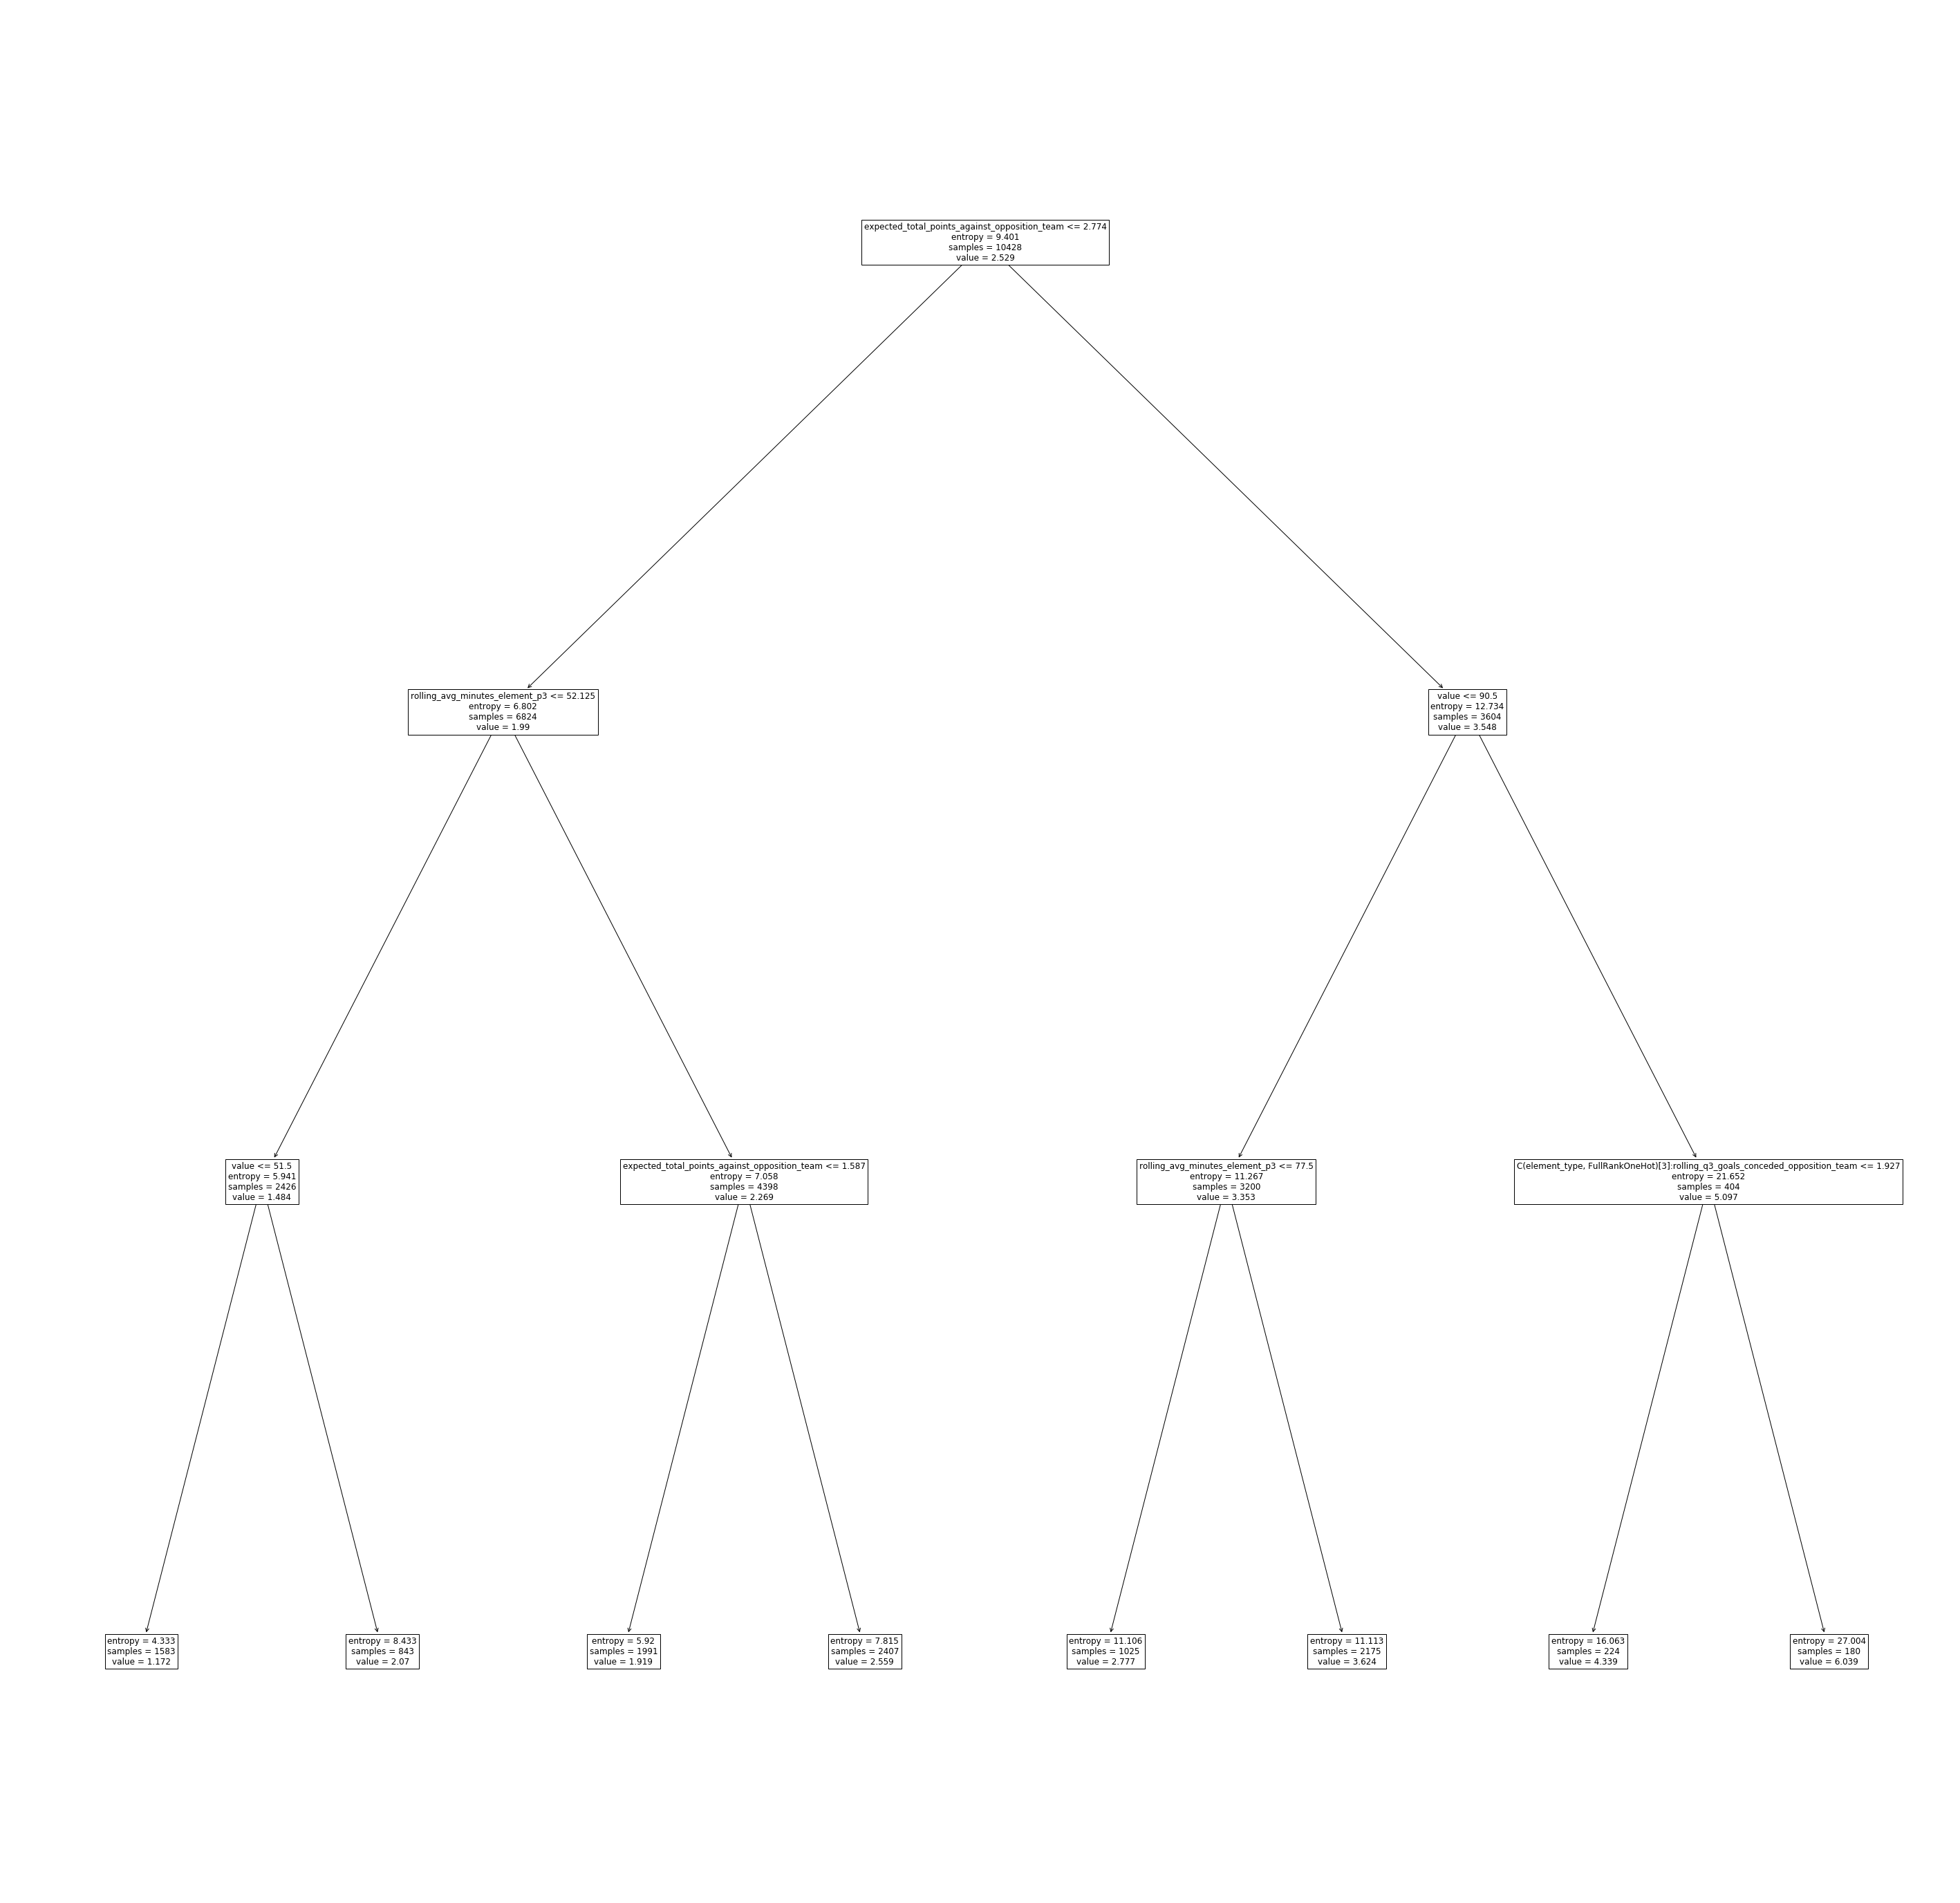

In [58]:
plt.figure(figsize=(50, 50))
plot_tree(
    dt_model_full,
    feature_names=X.design_info.column_names,
    fontsize=12
)
plt.show()

### Grid search

In [59]:
?XGBRegressor

In [67]:
learning_rate = [0.03, 0.05, 0.07]
subsample = [0.4,0.6, 0.8]
colsample_bynode = [0.25, 0.5, 0.75]
reg_lambda = [0.1, 0.5, 1]
max_depth = [2, 4, 8]

gs_parameters = {
    'learning_rate': learning_rate,
    'subsample': subsample,
    'colsample_bynode': colsample_bynode,
    'reg_lambda': reg_lambda,
    'max_depth': max_depth
}

In [ ]:
gs_df_arr = []
for i in range(0, 20):
    print('grid search', i)
    gs = GridSearchCV(
        XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100
        ),
        gs_parameters,
        scoring='neg_mean_squared_error',
        refit=False,
        cv=ps,
        return_train_score=True,
        error_score=100, n_jobs=1, verbose=1)
    gs.fit(X, y.ravel())
    
    gs_df = pd.DataFrame(gs.cv_results_)
    gs_df_arr.append(gs_df)

grid search 0
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 1
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 2
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 3
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 4
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 5
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 6
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 7
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 8
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 9
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 10
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 11
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 12
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 13
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 14
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 15
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 16
Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  7.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


grid search 17
Fitting 1 folds for each of 243 candidates, totalling 243 fits


In [ ]:
gs_df = pd.concat(gs_df_arr)
[[
    'param_learning_rate',
    'param_subsample',
    'param_reg_lambda',
    'param_max_depth',
    'mean_test_score',
    'mean_train_score'
]]

# Evaluating model

## XGBoost

In [ ]:
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    subsample=1.0,
    learning_rate=0.015,
    colsample_bylevel=0.2,
    reg_lambda=0.005,
    max_depth=15,
)

model.fit(X_train, y_train.ravel())

In [ ]:
# get predictions for test set
y_pred = model.predict(X_test).flatten()

# calculate cross entropy loss for test set
test_loss = (
    mean_absolute_error(y_test, y_pred),
    mean_squared_error(y_test, y_pred),
    r2_score(y_test, y_pred)
)
test_loss

In [ ]:
# refit model on all data
model_full = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    subsample=1.0,
    learning_rate=0.015,
    colsample_bylevel=0.2,
    reg_lambda=0.005,
    max_depth=15
)

model_full.fit(X, y.ravel())

In [ ]:
# get predictions for whole set
y_pred_full = model_full.predict(X).flatten()

# calculate cross entropy loss for test set
test_loss_full = (
    mean_absolute_error(y, y_pred_full),
    mean_squared_error(y, y_pred_full),
    r2_score(y, y_pred_full)
)
test_loss_full

In [ ]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [ ]:
pd.DataFrame([
    ('XGBoost', test_loss[0], test_loss[1], test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

In [ ]:
pd.DataFrame([
    ('XGBoost', test_loss_full[0], test_loss_full[1], test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])